In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score

import dask
import multiprocessing
from joblib import delayed, Parallel, parallel_backend
pd.options.display.max_rows = 100000
pd.options.display.max_colwidth = 1000


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Oda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Oda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading data

In [66]:
cores = multiprocessing.cpu_count()

In [67]:
train_data = pd.read_csv("./TrainX.csv")
test_data = pd.read_csv("./TestXL.csv")

### Remove recurring tweets to prevent ambiguity

In [68]:
train_tweets=train_data['tweet_clean'].tolist()
test_tweets=test_data['tweet_clean'].tolist()

In [69]:
def keep_uniques(array, df):
    dels=[]
    for i in array:
        if array.count(i)>1:
            dels.append(i)
    dels=list(set(dels))
    for i in dels:
        df.drop( df[ df['tweet_clean'] == i ].index, inplace=True)
    return df

In [70]:
train_data=keep_uniques(train_tweets, train_data)
test_data=keep_uniques(test_tweets, test_data)

In [71]:
len(train_data['tweet_clean'].unique())

6631

In [72]:
len(test_data['tweet_clean'].unique())

1976

### Exploring Dataset

In [73]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,6631.0,3355.129845,1935.640005,0.0,1683.5,3352.0,5030.5,6703.0


In [74]:
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)

In [75]:
train_data['klasifikasi'].value_counts()

Positif    2870
Netral     2621
Negatif    1140
Name: klasifikasi, dtype: int64

Here, we see that the `regular` class has 18k tweets, which causes our dataset to be imbalanced. So we shall delete some tweets from this class

In [77]:
temp=train_data.loc[train_data['klasifikasi'] == 'Netral']
lis=temp['tweet_clean'].tolist()

import random
reg_del=[]
visited=set()
for _ in range(1000):
    n=random.randint(0,2621)
    if n not in visited:
        reg_del.append(lis[n])

temp=train_data.loc[train_data['klasifikasi'] == 'Positif']
lis=temp['tweet_clean'].tolist()

import random
reg_del=[]
visited=set()
for _ in range(1000):
    n=random.randint(0,2870)
    if n not in visited:
        reg_del.append(lis[n])
        
for i in reg_del:
    train_data.drop( train_data[ train_data['tweet_clean'] == i ].index, inplace=True)

In [78]:
train_data['klasifikasi'].value_counts()

Netral     2621
Positif    2012
Negatif    1140
Name: klasifikasi, dtype: int64

In [79]:
test_data['klasifikasi'].value_counts()

Netral     1176
Positif     494
Negatif     309
Name: klasifikasi, dtype: int64

In [80]:
test_data = test_data.dropna()

## Data Cleaning & Preprocessing

In [81]:
def clean(tweet): 
    

    # Special characters
    tweet = re.sub(r"\x89Û_", "", str(tweet))
    tweet = re.sub(r"\x89ÛÒ", "", str(tweet))
    tweet = re.sub(r"\x89ÛÓ", "", str(tweet))
    tweet = re.sub(r"\x89ÛÏWhen", "When", str(tweet))
    tweet = re.sub(r"\x89ÛÏ", "", str(tweet))
    tweet = re.sub(r"China\x89Ûªs", "China's", str(tweet))
    tweet = re.sub(r"let\x89Ûªs", "let's", str(tweet))
    tweet = re.sub(r"\x89Û÷", "", str(tweet))
    tweet = re.sub(r"\x89Ûª", "", str(tweet))
    tweet = re.sub(r"\x89Û\x9d", "", str(tweet))
    tweet = re.sub(r"å_", "", str(tweet))
    tweet = re.sub(r"\x89Û¢", "", str(tweet))
    tweet = re.sub(r"\x89Û¢åÊ", "", str(tweet))
    tweet = re.sub(r"fromåÊwounds", "from wounds", str(tweet))
    tweet = re.sub(r"åÊ", "", str(tweet))
    tweet = re.sub(r"åÈ", "", str(tweet))
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    #emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    tweet =  emoji_pattern.sub(r'', tweet)
    
    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", str(tweet))
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", str(tweet))
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", str(tweet))
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", str(tweet))
    tweet = re.sub(r"doesn\x89Ûªt", "does not", str(tweet))
    tweet = re.sub(r"It\x89Ûªs", "It is", str(tweet))
    tweet = re.sub(r"Here\x89Ûªs", "Here is", str(tweet))
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", str(tweet))
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", str(tweet))
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", str(tweet))
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", str(tweet))
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", str(tweet))
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", str(tweet))
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", str(tweet))
    tweet = re.sub(r"you\x89Ûªll", "you will", str(tweet))
    tweet = re.sub(r"I\x89Ûªd", "I would", str(tweet))
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)
        
    #Punctuations and special characters
    
    tweet = re.sub('[%s]' % re.escape(string.punctuation),'',tweet)
    
    tweet = tweet.lower()
    
    splits = tweet.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    tweet = ' '.join(splits)
    
    
    return tweet

In [82]:
train_data['cleaned_text']= train_data['tweet_clean'].apply((lambda x: clean(x))) 
test_data['cleaned_text'] = test_data['tweet_clean'].apply((lambda x: clean(x)))
print("Cleaned")

Cleaned


In [83]:
train_data.head()

,Unnamed: 0,tweet_clean,klasifikasi,cleaned_text
6165,6165,"hi zakiyah, link to the information regarding the service of xlhome fiber via dm, thanks fitri",Positif,hi zakiyah link information regarding service xlhome fiber via dm thanks fitri
6469,6469,xlhome adam came in to see bro,Netral,xlhome adam came see bro
2510,2510,hi kak made kait layan xlhome fiber via dm ya thanks dian,Positif,hi kak made kait layan xlhome fiber via dm ya thanks dian
4897,4897,hi faris ada bantu xlhome thanks adi,Positif,hi faris ada bantu xlhome thanks adi
87,87,"xlhome is really bad, kaahhh",Negatif,xlhome really bad kaahhh


## EDA and Visualization

In [84]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(train_data['klasifikasi'])

ValueError: could not convert string to float: 'Positif'

Text(0.5, 1.0, 'Negatif Tweets')

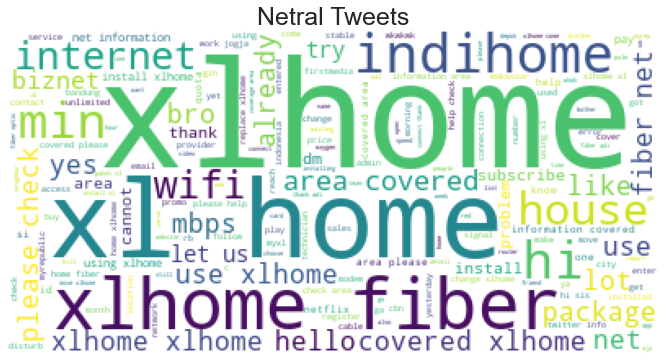

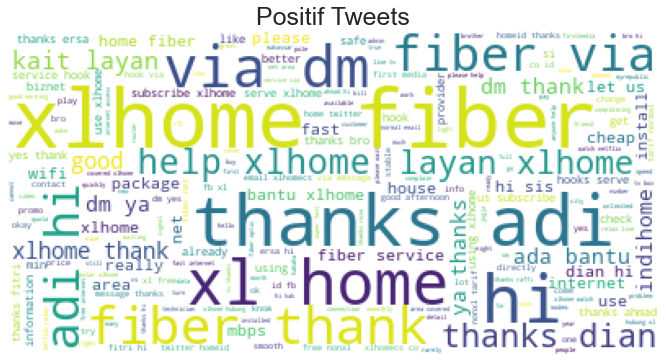

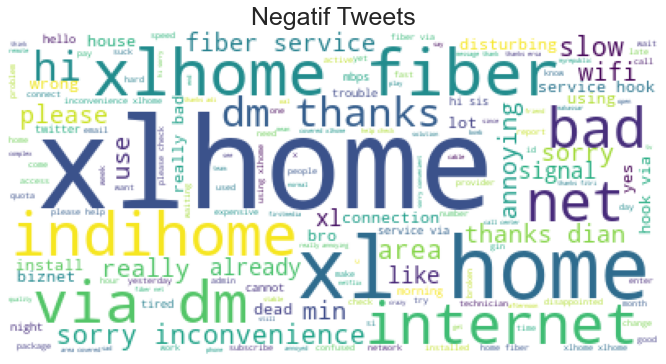

In [85]:
from wordcloud import WordCloud
stopwords = nltk.corpus.stopwords.words('english')

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['klasifikasi']=='Netral'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.title('Netral Tweets',fontsize=25)

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['klasifikasi']=='Positif'])
wc1 = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc1)
plt.axis('off')
plt.title('Positif Tweets',fontsize=25)

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['klasifikasi']=='Negatif'])
wc2 = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc2)
plt.axis('off')
plt.title('Negatif Tweets',fontsize=25)

# plt.figure(figsize=(12,6))
# text = ' '.join(train_data.cleaned_text[train_data['class']=='figurative'])
# wc3 = WordCloud(background_color='white',stopwords=stopwords).generate(text)
# plt.imshow(wc3)
# plt.axis('off')
# plt.title('Figurative Tweets',fontsize=25)

### Encode our text classes

In [86]:
def encode_target(t_class):
    t_class=str(t_class)
    class_dict = {
        'Negatif':0,
        'Netral':1,
        'Positif':2,
    }
    return class_dict[t_class]

In [87]:
train_data["target"] = train_data['klasifikasi'].apply(lambda x: encode_target(x))
test_data["target"] = test_data['klasifikasi'].apply(lambda x: encode_target(x))

In [88]:
train_data.tail()
test_data.tail()

,content,id,trans_eng,tweet_clean,tweet_english,klasifikasi,cleaned_text,target
2014,@xlhomeid @XLCare Mohon para petinggi xlhome menyikapi hal ini.\r\nSaya calon pelanggan xlhome di denpasar. Dr jadwal pemasangan tim xlhome sdh molor dr janji 1 minggu. Kemudian saya dijanjikan aktivasi modem paling lambat 1 hari sdh aktif. Tp skr sdh 3 hari belum juga aktif!,1172062667613163520,@xlhomeid @xlcare please Xlhome officials respond to this.\r\nI am a prospective XLHOME customer in Denpasar. From the XLHOME team installation schedule SDH delayed from the promise of 1 week. Then I was promised a modem activation no later than 1 day active. But now it's 3 days not yet active!,please Xlhome officials respond to this.I am a prospective XLHOME customer in Denpasar. From the XLHOME team installation schedule SDH delayed from the promise of week. Then I was promised a modem activation no later than day active. But now it's days not yet active!,please xlhome officials respond to this.i am a prospective xlhome customer in denpasar. from the xlhome team installation schedule sdh delayed from the promise of week. then i was promised a modem activation no later than day active. but now it's days not yet active!,Negatif,please xlhome officials respond thisi prospective xlhome customer denpasar xlhome team installation schedule sdh delayed promise week promised modem activation later day active days yet active,0
723,"@indirrash Hi Indira, adakah yang bisa kami bantu mengenai XLHome Fiber? #Thanks^AdI :)",1253201781603004417,"@Indirrash Hi Indira, can we help you about Xlhome Fiber? #Thanks^Adi :)","Hi Indira, can we help you about Xlhome Fiber? ^Adi","hi indira, can we help you about xlhome fiber? ^adi",Netral,hi indira help xlhome fiber adi,1
336,"@deviandrialdi Hi Devi, setelah kami bantu cek untuk saat ini alamat Devi belum ter-cover jaringan XLHome Fiber. Untuk informasi lebih lanjut apakah area Devi sudah ter-cover atau belum, silahkan cek disini https://t.co/0QqojBNA5H, ya. #Thanks ^Dian",1260191744429223941,"@deviandrialdi Hi Devi, after we help check for now Devi's address has not been covered by the Xlhome Fiber network. For more information whether the Devi area has been covered or not, please check here https://t.co/0qqojbna5h, yes. #Thanks ^Dian","Hi Devi, after we help check for now Devi's address has not been covered by the Xlhome Fiber network. For more information whether the Devi area has been covered or not, please check here , yes. ^Dian","hi devi, after we help check for now devi's address has not been covered by the xlhome fiber network. for more information whether the devi area has been covered or not, please check here , yes. ^dian",Positif,hi devi help check devis address covered xlhome fiber network information whether devi area covered please check yes dian,2
17,"@xlhomeid dear xlhome tolong check DM, thx.",1268169067459825665,"@xlhomeid dear xlhome please check dm, thx.","dear xlhome please check dm, thx.","dear xlhome please check dm, thx.",Netral,dear xlhome please check dm thx,1
492,"@Roy96517416 Hi Roy, adakah yang bisa kami bantu mengenai XLHome? #Thanks ^AdI :)",1257103576872050689,"@Roy96517416 Hi Roy, can we help you about Xlhome? #Thanks ^adi :)","Hi Roy, can we help you about Xlhome? ^adi","hi roy, can we help you about xlhome? ^adi",Netral,hi roy help xlhome adi,1


### Preparing our train and test sets

In [89]:
train = train_data[['cleaned_text','target']]
train.columns = ['text','labels']

test = test_data[['cleaned_text','target']]
test.columns = ['text','labels']

In [90]:
train.head()

,text,labels
6165,hi zakiyah link information regarding service xlhome fiber via dm thanks fitri,2
6469,xlhome adam came see bro,1
2510,hi kak made kait layan xlhome fiber via dm ya thanks dian,2
4897,hi faris ada bantu xlhome thanks adi,2
87,xlhome really bad kaahhh,0


In [91]:
test.head()

,text,labels
303,sis make kt place covered network really want use xlhome id,2
646,good xlhome,2
859,xlhome jannnn xl axiata,1
1003,area nty mncplay pretty cheap myrepublic fast xlhome also said good speed,2
1378,accordance previous information xlhome fiber packages fup limits adi,0


In [92]:
traintexts=train['text'].tolist()
testtexts=test['text'].tolist()

all_texts = traintexts + testtexts

## Feature Extraction

### 1. Count Vectors

In [93]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(all_texts)

# transform the training and test data using count vectorizer object
xtrain_count =  count_vect.transform(train['text'])
xtest_count =  count_vect.transform(test['text'])

### 2. Word level tf-idf

In [94]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=55000)
tfidf_vect.fit(all_texts)
xtrain_tfidf =  tfidf_vect.transform(train['text'])
xtest_tfidf =  tfidf_vect.transform(test['text'])

### 3. Hashing Vectorizer

In [95]:
hash_vectorizer = HashingVectorizer(n_features=55000)
hash_vectorizer.fit(all_texts)
xtrain_hash_vectorizer =  hash_vectorizer.transform(train['text']) 
xtest_hash_vectorizer =  hash_vectorizer.transform(test['text'])

## Building the Model

In [96]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    return metrics.accuracy_score(predictions, test_y)

### Naive Bayes Classifier

In [97]:
print("NAIVE BAYES CLASSIFIER")
print("========================================================")
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Naive Bayes on Hash Vectors
# accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
# print("-> Hash Vectors Accuracy: ", round(accuracy,2))

NAIVE BAYES CLASSIFIER
-> Count Vectors Accuracy: 54.379999999999995% 
-> WordLevel TF-IDF Accuracy: 53.52%


### Linear Classifier

In [98]:
print("LINEAR CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

LINEAR CLASSIFIER
-> Count Vectors Accuracy: 83.85000000000001% 
-> WordLevel TF-IDF Accuracy: 76.51%
-> Hash Vectors Accuracy: 79.14%


### XGBoost Classifier

In [99]:

print("XGBOOST CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

XGBOOST CLASSIFIER
-> Count Vectors Accuracy: 84.71% 
-> WordLevel TF-IDF Accuracy: 84.0%
-> Hash Vectors Accuracy: 84.05%


In [100]:
from sklearn.neighbors import KNeighborsClassifier

In [101]:
print("KNN CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(KNeighborsClassifier(n_neighbors = 80, n_jobs=4) , xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(KNeighborsClassifier(n_neighbors = 80, n_jobs=4) , xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(KNeighborsClassifier(n_neighbors = 80, n_jobs=4) , xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

KNN CLASSIFIER
-> Count Vectors Accuracy: 47.65% 
-> WordLevel TF-IDF Accuracy: 47.04%
-> Hash Vectors Accuracy: 43.34%


In [102]:
from sklearn.linear_model import SGDClassifier

In [103]:
print("SGD CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(SGDClassifier(max_iter=500, n_jobs=4) , xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(SGDClassifier(max_iter=500, n_jobs=4) , xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(SGDClassifier(max_iter=500, n_jobs=4) , xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

SGD CLASSIFIER
-> Count Vectors Accuracy: 85.00999999999999% 
-> WordLevel TF-IDF Accuracy: 83.89999999999999%
-> Hash Vectors Accuracy: 83.49%


In [104]:
from sklearn.svm import LinearSVC

In [105]:
print("LINEAR SVC CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(LinearSVC(max_iter=3500) , xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(LinearSVC(max_iter=3500) , xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(LinearSVC(max_iter=3500) , xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

LINEAR SVC CLASSIFIER
-> Count Vectors Accuracy: 85.57000000000001% 
-> WordLevel TF-IDF Accuracy: 83.59%
-> Hash Vectors Accuracy: 83.49%
